## CATE estimators example

In [5]:
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from upliftml.models.pyspark import (
    SLearnerEstimator,
    TLearnerEstimator,
    CVTEstimator,
    TransformedOutcomeEstimator,
    XLearnerEstimator
)

from upliftml.evaluation import (
    estimate_ate,
    estimate_and_plot_cate_per_bucket,
    estimate_and_plot_cate_per_quantile,
    estimate_and_plot_cate_lift,
    estimate_and_plot_qini
)

from upliftml.datasets import simulate_randomized_trial

### Specify plot style


In [6]:
sns.set(font_scale=1.5, style='ticks', rc={'figure.figsize':(11, 7)}) 

### Read dataframe

In [7]:
df_pd = simulate_randomized_trial(n=2000, p=6, sigma=1.0, binary_outcome=True)
df_spark = spark.createDataFrame(df_pd)

In [8]:
df_spark.cache().count() 

2000

In [9]:
df_spark.limit(5).toPandas() 

,treatment,outcome,propensity,expected_outcome,actual_cate,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
0,0,1,0.5,2.081468,0.213683,-0.060721,0.928439,1.191274,0.699331,-0.676854,0.546311
1,1,1,0.5,5.988552,0.042089,1.707866,1.705622,1.563086,-1.375008,2.386985,-0.213880
2,0,0,0.5,0.132429,0.295410,0.279862,0.755178,-0.902611,-1.751023,0.268627,2.113189
3,0,1,0.5,1.340540,-0.130917,-0.237295,-0.177829,-0.007501,0.557275,0.783264,0.687158
4,1,1,0.5,0.544157,0.291012,-1.374546,0.595552,-0.031449,-0.058209,0.602366,0.481760


### Estimate overall ATE

In [10]:
target_col = 'outcome'

results = estimate_ate(df_spark,
                       target_colname=target_col,
                       bootstrap=True,
                       n_bootstraps=300,
                       ci_quantiles=[0.025, 0.975])

print('{} rate control: {:.4f}, lower: {:.4f}, upper: {:.4f}'.format(target_col, results['target_rate_control'], results['target_rate_control_lower'], results['target_rate_control_upper']))
print('{} rate treated: {:.4f}, lower: {:.4f}, upper: {:.4f}'.format(target_col, results['target_rate_treated'], results['target_rate_treated_lower'], results['target_rate_treated_upper']))
print('{} ATE: {:.4f}, lower: {:.4f}, upper: {:.4f}'.format(target_col, results['ate'], results['ate_lower'], results['ate_upper']))
print('')

outcome rate control: 0.7041, lower: 0.6760, upper: 0.7298
outcome rate treated: 0.8124, lower: 0.7898, upper: 0.8383
outcome ATE: 0.1082, lower: 0.0717, upper: 0.1446



### Exploratory analysis


### Plot CATE by bucket, based on categories from a categorical feature

In [11]:
# Add a categorical feature 'bucket'
df_spark_with_bucket = df_spark.withColumn('bucket', F.col('feature_1').cast('int'))

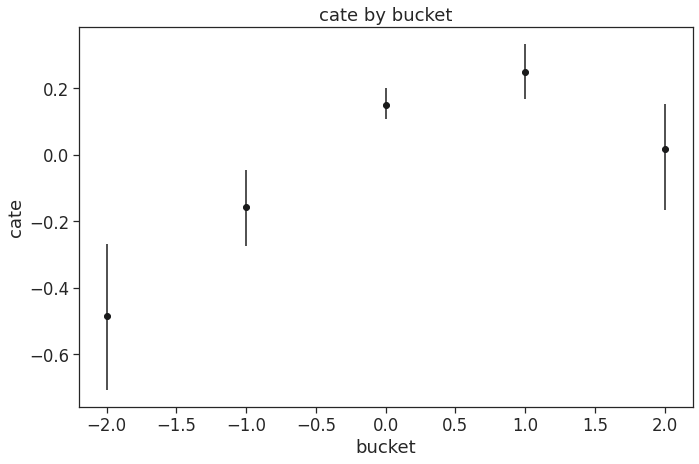

In [12]:
df_barplot, ax = estimate_and_plot_cate_per_bucket(df_spark_with_bucket, 
                                                  bucket_colname='bucket', 
                                                  target_colname='outcome',
                                                  bootstrap=True, 
                                                  n_bootstraps=300)

#### Generate buckets based on quantiles and plot CATE by bucket

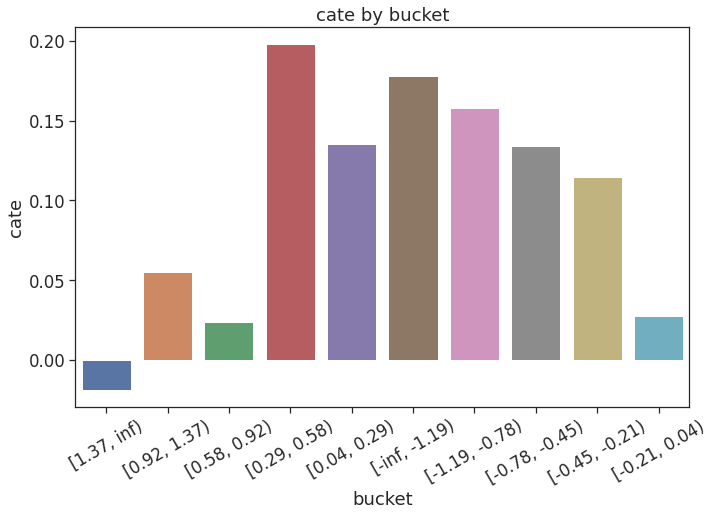

In [13]:
df_cate, ax = estimate_and_plot_cate_per_quantile(df_spark, 
                                    n_buckets=10, 
                                    score_colname='feature_3', 
                                    target_colname='outcome', 
                                    add_labels=True,
                                    sort_x=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);

### CATE estimators

#### Train/Test Split

In [14]:
df_train, df_val, df_test = df_spark.randomSplit([0.5, 0.25, 0.25])

#### Assemble features

In [15]:
def get_features_vector(df, num_features, cat_features):
    
    df_cols = df.columns
    indexers = [StringIndexer(inputCol = c, outputCol="{0}_indexed".format(c)) for c in cat_features]
    encoders = [StringIndexer(inputCol = indexer.getOutputCol(), outputCol = "{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers]
    assemblerCat = VectorAssembler(inputCols = [encoder.getOutputCol() for encoder in encoders], outputCol = "cat")

    pipelineCat = Pipeline(stages = indexers + encoders + [assemblerCat])
    df = pipelineCat.fit(df).transform(df)

    assemblerNum = VectorAssembler(inputCols = num_features, outputCol = "num")
    pipelineNum = Pipeline(stages = [assemblerNum])
    df = pipelineNum.fit(df).transform(df)

    assembler = VectorAssembler(inputCols = ["cat", "num"], outputCol = "features")

    pipeline = Pipeline(stages = [assembler])
    df_assembled = pipeline.fit(df).transform(df)

    return df_assembled.select([*df_cols,'features'])

In [16]:
num_features = [
    'feature_1',
    'feature_2',
    'feature_3',
    'feature_4',
    'feature_5',
    'feature_6'
]

cat_features = []

df_train_assembled = get_features_vector(df_train, num_features, cat_features)
df_val_assembled = get_features_vector(df_val, num_features, cat_features)
df_test_assembled = get_features_vector(df_test, num_features, cat_features)

#### Define models parameters

In [17]:
predictors_colname = 'features'
target_colname = 'outcome'
treatment_colname = 'treatment'
treatment_value = 1
control_value = 0

base_model_class_cls = LogisticRegression
base_model_params_cls = {'maxIter': 15}
base_model_class_reg = LinearRegression
base_model_params_reg = {}

#### Initialize Estimators

In [18]:
estimator_S = SLearnerEstimator(base_model_class=base_model_class_cls,
                                            base_model_params=base_model_params_cls,
                                            predictors_colname=predictors_colname,
                                            target_colname=target_colname,
                                            treatment_colname=treatment_colname,
                                            treatment_value=treatment_value,
                                            control_value=control_value,
                                            output_colname='cate_s')

estimator_T = TLearnerEstimator(base_model_class=base_model_class_cls,
                                            base_model_params=base_model_params_cls,
                                            predictors_colname=predictors_colname,
                                            target_colname=target_colname,
                                            treatment_colname=treatment_colname,
                                            treatment_value=treatment_value,
                                            control_value=control_value,
                                            output_colname='cate_t')

estimator_X = XLearnerEstimator(base_model_class_1=base_model_class_cls,
                                        base_model_params_1=base_model_params_cls,
                                        base_model_class_2=base_model_class_reg,
                                        base_model_params_2=base_model_params_reg,
                                        predictors_colname_1=predictors_colname,
                                        predictors_colname_2=predictors_colname,
                                        target_colname=target_colname,
                                        treatment_colname=treatment_colname,
                                        treatment_value=treatment_value,
                                        control_value=control_value,
                                        output_colname='cate_x')

estimator_CVT = CVTEstimator(base_model_class=base_model_class_cls,
                                        base_model_params=base_model_params_cls,
                                        predictors_colname=predictors_colname,
                                        target_colname=target_colname,
                                        treatment_colname=treatment_colname,
                                        output_colname='cate_cvt')

estimator_TO = TransformedOutcomeEstimator(base_model_class=base_model_class_reg,
                                            base_model_params=base_model_params_reg,
                                            predictors_colname=predictors_colname,
                                            target_colname=target_colname,
                                            treatment_colname=treatment_colname,
                                            treatment_value=treatment_value,
                                            control_value=control_value,
                                            output_colname='cate_to')

#### Train the Estimators

In [19]:
estimator_S.fit(df_train_assembled, df_val_assembled)
estimator_T.fit(df_train_assembled, df_val_assembled)
estimator_X.fit(df_train_assembled, df_val_assembled)
estimator_CVT.fit(df_train_assembled, df_val_assembled)
estimator_TO.fit(df_train_assembled, df_val_assembled)

#### Predict CATE scores on test set 

In [20]:
df_test_eval = estimator_S.predict(df_test_assembled)
df_test_eval = estimator_T.predict(df_test_eval)
df_test_eval = estimator_X.predict(df_test_eval)
df_test_eval = estimator_CVT.predict(df_test_eval)
df_test_eval = estimator_TO.predict(df_test_eval)

### Evaluate

In [21]:
df_test_eval.limit(10).toPandas()

,treatment,outcome,propensity,expected_outcome,actual_cate,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,features,cate_s,cate_t,cate_x,cate_cvt,cate_to
0,0,0,0.52621,0.0,-0.100551,-0.694349,-0.924707,0.014347,0.048789,-3.231800,-1.331446,"[-0.6943488666349152, -0.9247073746425801, 0.0...",0.119925,-0.112918,0.011770,0.041301,-0.018684
1,0,0,0.52621,0.0,-0.023169,0.501870,-1.542663,-0.448666,-0.751408,-0.452367,-0.461186,"[0.5018701276711648, -1.5426628607162307, -0.4...",0.156110,0.260631,0.186924,0.203672,0.177215
2,0,0,0.52621,0.0,-0.006741,-0.290086,-1.079935,1.258341,-1.069564,0.173151,-1.580633,"[-0.29008642626300385, -1.0799349741718047, 1....",0.109321,-0.001487,-0.022165,0.005259,0.054805
3,0,0,0.52621,0.0,0.138278,-0.350176,-1.168675,0.050894,-0.721480,-0.992572,0.327815,"[-0.3501759156996482, -1.1686753283481237, 0.0...",0.155534,-0.020672,0.045989,0.061717,0.024879
4,0,0,0.52621,0.0,0.306826,-0.006623,-1.410832,-0.234213,0.282347,-0.751689,0.578137,"[-0.006622738666520826, -1.410832391573642, -0...",0.154628,0.080345,0.076763,0.105680,0.068533
5,0,0,0.52621,0.0,0.315615,-1.829893,0.424346,-0.477382,0.740113,-0.910922,1.266189,"[-1.8298929122564436, 0.4243459699366228, -0.4...",0.139022,-0.324173,-0.163385,-0.204377,-0.320399
6,0,0,0.52621,0.0,0.329630,-1.429726,0.304485,-0.012937,-0.709935,-0.461301,-2.584882,"[-1.429726304376938, 0.30448506712657913, -0.0...",0.139318,-0.193013,-0.102672,-0.150660,-0.202394
7,0,0,0.52621,0.0,0.363128,1.634456,-0.881603,-0.946567,0.221870,-2.066115,-0.969887,"[1.63445559894502, -0.881602905896248, -0.9465...",0.154192,0.593978,0.398515,0.407555,0.370996
8,0,0,0.52621,0.0,0.376266,-1.162569,-0.221795,-0.595617,-0.909180,0.777347,1.858744,"[-1.1625691317333167, -0.22179479270508173, -0...",0.144237,-0.137583,-0.046238,-0.098701,-0.185871
9,0,0,0.52621,0.0,0.421804,1.131116,-0.644805,-1.466379,-0.133161,-0.722994,0.211802,"[1.1311158429968187, -0.6448051935833988, -1.4...",0.156975,0.523771,0.344344,0.324825,0.245175


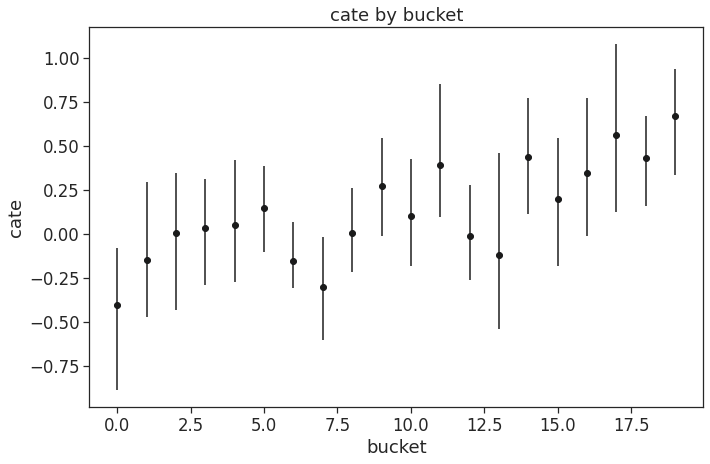

In [22]:
df_barplot, ax = estimate_and_plot_cate_per_quantile(df_test_eval, 
                                                    n_buckets=20, 
                                                    score_colname='cate_t',
                                                    target_colname='outcome', 
                                                    bootstrap=True, 
                                                    n_bootstraps=100)

#### CATE lift

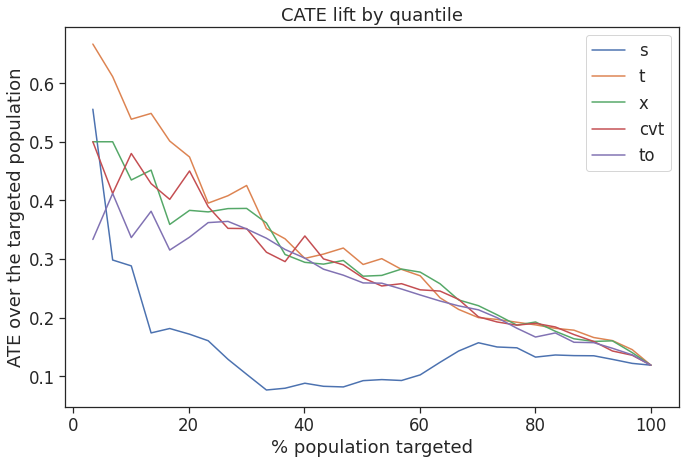

In [23]:
for model_name in ['s', 't', 'x', 'cvt', 'to']:
    estimate_and_plot_cate_lift(df_test_eval, 
                               score_colname=f'cate_{model_name}', 
                               target_colname='outcome', 
                               label=model_name)

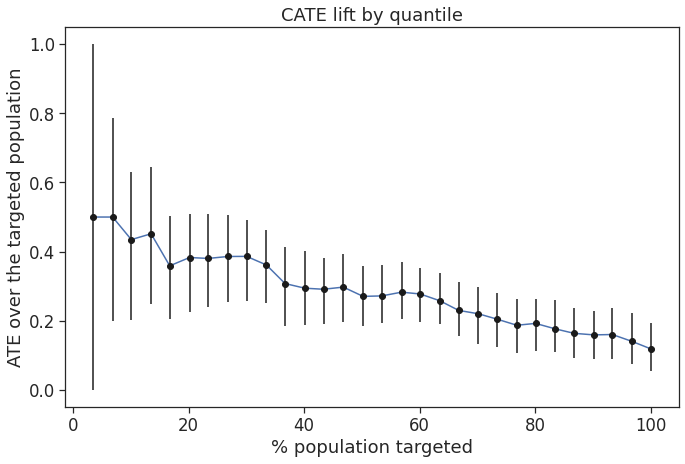

In [24]:
 # with bootstrapping
_, _ = estimate_and_plot_cate_lift(df_test_eval, 
                                  score_colname='cate_x', 
                                  target_colname='outcome', 
                                  bootstrap=True, 
                                  n_bootstraps=100)

#### Qini

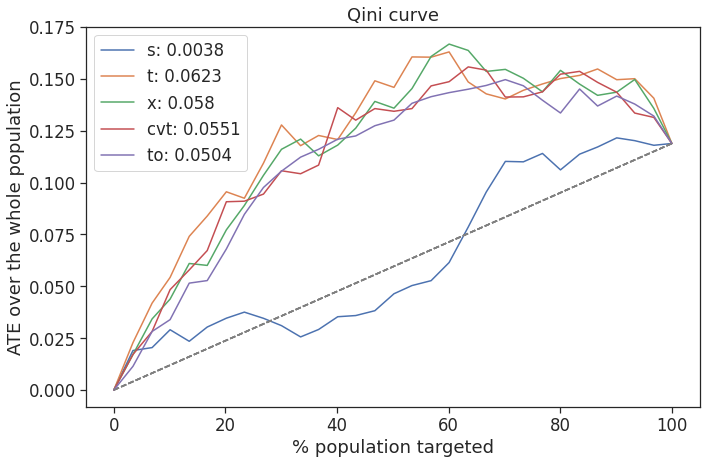

In [25]:
for model_name in ['s', 't', 'x', 'cvt', 'to']:
    estimate_and_plot_qini(df_test_eval,
                          score_colname=f'cate_{model_name}', 
                          target_colname='outcome', 
                          label=model_name)

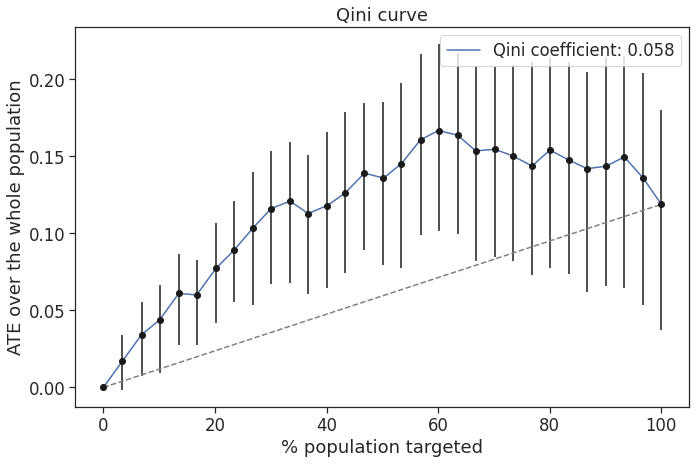

In [26]:
 # with bootstrapping
_, _ = estimate_and_plot_qini(df_test_eval, 
                             score_colname='cate_x', 
                             target_colname='outcome', 
                             bootstrap=True, 
                             n_bootstraps=100)

### Plotting with Subplots

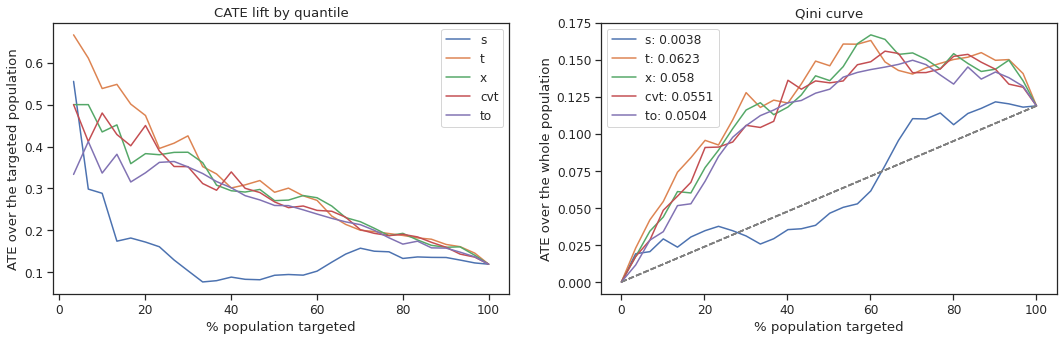

In [27]:
sns.set(font_scale=1.1, style='ticks', rc={'figure.figsize':(18, 5)})

fig, axes = plt.subplots(1, 2)

for model_name in ['s', 't', 'x', 'cvt', 'to']:
    estimate_and_plot_cate_lift(df_test_eval, 
                               score_colname=f'cate_{model_name}', 
                               target_colname='outcome', 
                               label=model_name,
                               ax=axes[0])
    
for model_name in ['s', 't', 'x', 'cvt', 'to']:
    estimate_and_plot_qini(df_test_eval, 
                          score_colname=f'cate_{model_name}', 
                          target_colname='outcome', 
                          label=model_name,
                          ax=axes[1])

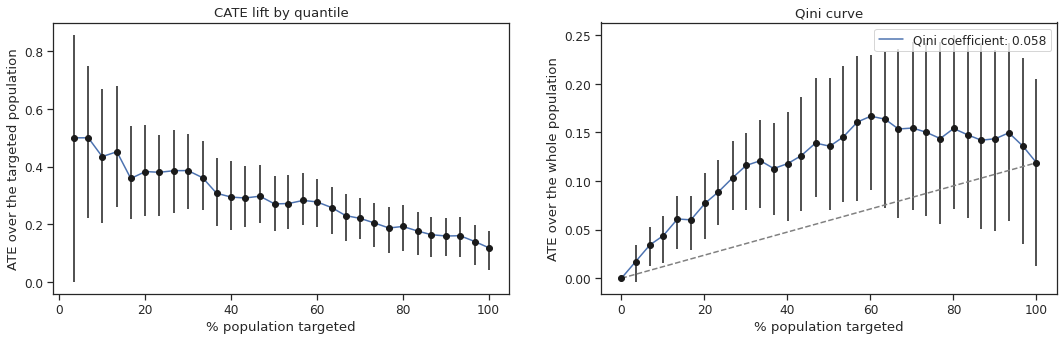

In [28]:
sns.set(font_scale=1.1, style='ticks', rc={'figure.figsize':(18, 5)})

fig, axes = plt.subplots(1, 2)

_, _ = estimate_and_plot_cate_lift(df_test_eval, 
                                  score_colname='cate_x', 
                                  target_colname='outcome', 
                                  bootstrap=True, 
                                  n_bootstraps=100,
                                  ax=axes[0])
    
_, _ = estimate_and_plot_qini(df_test_eval, 
                             score_colname='cate_x', 
                             target_colname='outcome', 
                             bootstrap=True, 
                             n_bootstraps=100,
                             ax=axes[1])